# Код для сборы базы данных треков для глубокого обучение ML-моделей 

## Подключаем библиотеки

In [30]:
from pathlib import Path
import pandas as pd
import os
from spotipy import Spotify
from spotipy.oauth2 import SpotifyClientCredentials

from http.server import HTTPServer, SimpleHTTPRequestHandler
from datetime import datetime, timedelta

from cryptography import x509
from cryptography.x509.oid import NameOID
from cryptography.hazmat.primitives import serialization, hashes
from cryptography.hazmat.primitives.asymmetric import rsa

import tempfile
import shutil
from concurrent.futures import ThreadPoolExecutor, as_completed
import browser_cookie3 as bc
from http import cookiejar as cj
from yt_dlp import YoutubeDL

import matplotlib.pyplot as plt
import seaborn as sns

## Поднимаем свой https сервер

In [ ]:
CERT_FILE = "cert.pem"
KEY_FILE = "key.pem"

def generate_self_signed_cert(hostname: str):
    """
    Генерирует самоподписанный сертификат и приватный ключ.
    Сохраняет их в файлы KEY_FILE и CERT_FILE.
    :param hostname: Имя хоста (или IP), для которого создаётся сертификат.
    """
    # 1. Генерация RSA-ключа длиной 2048 бит
    key = rsa.generate_private_key(
        public_exponent=65537,  # стандартное значение e
        key_size=2048           # битность ключа
    )

    # 2. Сохранение приватного ключа в формате PEM, без пароля
    with open(KEY_FILE, "wb") as f:
        f.write(
            key.private_bytes(
                encoding=serialization.Encoding.PEM,
                format=serialization.PrivateFormat.TraditionalOpenSSL,
                encryption_algorithm=serialization.NoEncryption()
            )
        )

    # 3. Формирование субъектных данных (subject) сертификата
    subject = issuer = x509.Name([
        x509.NameAttribute(NameOID.COUNTRY_NAME, "RU"),                  # Страна
        x509.NameAttribute(NameOID.STATE_OR_PROVINCE_NAME, "Moscow"),    # Регион
        x509.NameAttribute(NameOID.LOCALITY_NAME, "Moscow"),             # Город
        x509.NameAttribute(NameOID.ORGANIZATION_NAME, "MyOrganization"), # Организация
        x509.NameAttribute(NameOID.COMMON_NAME, hostname),               # Общее имя (CN)
    ])

    # 4. Подготовка списка SAN: всегда добавляем DNS, а если hostname — IP, то и IP
    san_list = [
        x509.DNSName("localhost"),
        x509.IPAddress(ipaddress.IPv4Address("127.0.0.1"))
    ]
    try:
        ip = ipaddress.ip_address(hostname)  # пробуем распознать IP
        san_list.append(x509.IPAddress(ip))
    except ValueError:
        # Если это не IP, просто оставляем DNSName
        pass

    # 5. Построение сертификата
    cert = (
        x509.CertificateBuilder()
        .subject_name(subject)                              # Устанавливаем subject
        .issuer_name(issuer)                                # Устанавливаем issuer (самоподписанный)
        .public_key(key.public_key())                       # Публикуем ключ
        .serial_number(x509.random_serial_number())         # Случайный серийный номер
        .not_valid_before(datetime.utcnow() - timedelta(days=1))
        .not_valid_after(datetime.utcnow() + timedelta(days=365))
        .add_extension(
            x509.SubjectAlternativeName(san_list),           # Добавляем SAN
            critical=False
        )
        .sign(key, hashes.SHA256())                         # Подписываем сертификат
    )

    # 6. Сохранение сертификата в файл в формате PEM
    with open(CERT_FILE, "wb") as f:
        f.write(cert.public_bytes(serialization.Encoding.PEM))

    print(f"[+] Сгенерированы файлы:\n    {KEY_FILE}\n    {CERT_FILE}")

def ensure_cert(hostname: str):
    """
    Проверяет наличие файлов ключа и сертификата.
    Если файлов нет — вызывает генерацию.
    """
    if not (os.path.exists(KEY_FILE) and os.path.exists(CERT_FILE)):
        print("[*] Ключ или сертификат не найдены, генерируем новые...")
        generate_self_signed_cert(hostname)
    else:
        print("[*] Найдены существующие файлы ключа и сертификата, используем их.")

def run_https_server(host="127.0.0.1", port=5434):
    """
    Запускает HTTPS-сервер на заданном хосте и порту.
    :param host: IP-адрес или имя хоста (по умолчанию 127.0.0.1)
    :param port: Порт (по умолчанию 5434)
    """
    # Гарантируем наличие сертификата и ключа
    ensure_cert(host)

    # Настраиваем HTTPServer с обработчиком статических файлов
    httpd = HTTPServer((host, port), SimpleHTTPRequestHandler)

    # Создаём SSL-контекст для сервера
    context = ssl.SSLContext(ssl.PROTOCOL_TLS_SERVER)
    context.load_cert_chain(certfile=CERT_FILE, keyfile=KEY_FILE)

    # "Оборачиваем" сокет HTTP-сервера в TLS
    httpd.socket = context.wrap_socket(httpd.socket, server_side=True)

    print(f"[+] HTTPS-сервер запущен: https://{host}:{port}/")
    # Запускаем бесконечный цикл обработки запросов
    httpd.serve_forever()

if __name__ == "__main__":
    # Точка входа: запускаем сервер на 127.0.0.1:5434
    run_https_server()

[*] Найдены существующие файлы ключа и сертификата, используем их.
[+] HTTPS-сервер запущен: https://127.0.0.1:5434/


## Подключаемся к API Spotify 

In [ ]:
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id="305c243c894541f0967234116ce47b31",
                                               client_secret="dc4fb7a3625b4540a13cce26d919fd2f",
                                               redirect_uri="https://127.0.0.1:5434/callback",
                                               scope="user-library-read"))

In [ ]:
token = sp.auth_manager.get_access_token(as_dict=True) #запришиваем token 
print(token)

In [ ]:
genre_dict = {
    "pop": [
        "pop", "dance pop", "pop rock", "indie pop", "synthpop", "pop rap"
    ],
    "rock": [
        "rock", "classic rock", "hard rock", "alternative rock", "punk rock",
        "progressive rock"
    ],
    "hip hop": [
        "hip hop", "east coast hip hop", "west coast hip hop", "trap",
        "boom bap", "conscious hip hop", "emo rap", "phonk"
    ],
    "r&b": [
        "r&b", "contemporary r&b", "neo soul", "motown", "quiet storm",
        "funk", "urban contemporary"
    ],
    "edm": [
        "edm", "dance", "electropop", "electronica", "downtempo", "indietronica",
        "deep house", "future house"
    ],
    "country": [
        "country", "bluegrass", "honky tonk", "outlaw country", "country pop",
        "americana"
    ],
    "classical": [
        "classical", "baroque", "romantic", "contemporary classical", "opera",
        "chamber music"
    ],
    "metal": [
        "metal", "heavy metal", "thrash metal", "death metal", "black metal",
        "power metal", "metalcore", "deathcore", "screamo", "nu metal"
    ],
    "jazz": [
        "jazz", "bebop", "smooth jazz", "free jazz", "latin jazz", "jazz fusion",
        "cool jazz", "vocal jazz"
    ],
    "blues": [
        "blues", "delta blues", "chicago blues", "electric blues", "country blues",
        "soul blues", "texas blues", "memphis blues"
    ],
    "soul": [
        "soul", "northern soul", "southern soul", "neo soul", "blue-eyed soul",
        "psychedelic soul"
    ],
    "latin": [
        "latin", "reggaeton", "salsa", "bachata", "latin pop", "cumbia"
    ],
    "folk": [
        "folk", "indie folk", "traditional folk", "folk rock", "celtic folk",
        "americana"
    ],
    "reggae": [
        "reggae", "dub", "ska", "dancehall", "roots reggae", "ragga"
    ],
    "funk": [
        "funk", "p-funk", "funk rock", "electro-funk", "go-go", "funk metal"
    ],
    "punk": [
        "punk", "hardcore punk", "post-punk", "pop punk", "skate punk", "anarcho-punk"
    ],
    "disco": [
        "disco", "euro disco", "hi-nrg", "italo disco", "nu-disco", "space disco"
    ],
    "ambient": [
        "ambient", "dark ambient", "ambient techno", "drone", "chillout", "new age"
    ],
    "experimental": [
        "experimental", "noise", "avant-garde", "glitch", "musique concrète",
        "electroacoustic"
    ],
    "world": [
        "world", "afrobeat", "k-pop", "j-pop", "bhangra", "flamenco"
    ],
    "alternative": [
        "alternative", "indie rock", "indie pop", "shoegaze", "dream pop", "lo-fi"
    ],
    "trap": [
        "trap", "trap latino", "trap soul", "drill", "phonk", "cloud rap"
    ],
    "house": [
        "house", "deep house", "acid house", "chicago house", "tropical house", "future house"
    ],
    "techno": [
        "techno", "minimal techno", "detroit techno", "industrial techno", "acid techno", "tech trance"
    ],
    "trance": [
        "trance", "uplifting trance", "progressive trance", "psytrance", "vocal trance", "goa trance"
    ],
    "dubstep": [
        "dubstep", "brostep", "chillstep", "riddim", "melodic dubstep", "trapstep"
    ],
    "drum and bass": [
        "drum and bass", "liquid funk", "neurofunk", "jump up", "darkstep", "jungle"
    ],
    "industrial": [
        "industrial", "industrial rock", "ebm", "power noise", "industrial metal", "aggrotech"
    ],
    "ska": [
        "ska", "ska punk", "2-tone", "third wave ska", "ska jazz", "rocksteady"
    ],
    "emo": [
        "emo", "screamo", "emo pop", "post-hardcore", "midwest emo", "emo rap"
    ],
    "grunge": [
        "grunge", "post-grunge", "sludge metal", "stoner rock", "alternative metal", "noise rock"
    ],
    "new wave": [
        "new wave", "synthpop", "post-punk", "dark wave", "cold wave", "minimal wave"
    ],
    "lo-fi": [
        "lo-fi", "lo-fi hip hop", "lo-fi chill", "lo-fi beats", "bedroom pop", "indie lo-fi"
    ],
    "chillout": [
        "chillout", "downtempo", "lounge", "chillhop", "ambient pop", "trip hop"
    ],
    "trip hop": [
        "trip hop", "bristol sound", "acid jazz", "chillwave", "nu jazz", "downtempo"
    ],
    "jazz fusion": [
        "jazz fusion", "jazz rock", "latin fusion", "funk fusion", "world fusion", "smooth jazz"
    ],
    "progressive rock": [
        "progressive rock", "symphonic prog", "neo-prog", "canterbury scene", "space rock", "art rock"
    ],
    "psychedelic": [
        "psychedelic", "psychedelic rock", "psychedelic pop", "acid rock", "neo-psychedelia", "space rock"
    ],
    "hardcore": [
        "hardcore", "hardcore punk", "metalcore", "post-hardcore", "beatdown hardcore", "melodic hardcore"
    ],
    "metalcore": [
        "metalcore", "deathcore", "mathcore", "progressive metalcore", "melodic metalcore", "djent"
    ],
    "death metal": [
        "death metal", "technical death metal", "melodic death metal", "brutal death metal",
        "old school death metal", "deathgrind"
    ],
    "black metal": [
        "black metal", "symphonic black metal", "atmospheric black metal", "raw black metal",
        "depressive black metal", "post-black metal"
    ],
    "thrash metal": [
        "thrash metal", "crossover thrash", "groove metal", "speed metal",
        "bay area thrash", "teutonic thrash"
    ],
    "opera": [
        "opera", "bel canto", "contemporary opera", "baroque opera", "romantic opera", "dramatic soprano"
    ],
    "chamber music": [
        "chamber music", "string quartet", "piano trio", "wind quintet", "brass ensemble", "duet"
    ],
    "k-pop": [
        "k-pop", "k-pop boy group", "k-pop girl group", "k-indie", "k-rap", "k-rock"
    ],
    "j-pop": [
        "j-pop", "j-rock", "anisong", "vocaloid", "j-poprock", "j-trance"
    ],
    "afrobeat": [
        "afrobeat", "nigerian pop", "afropop", "afroswing", "azonto", "afro house"
    ],
    "latin jazz": [
        "latin jazz", "bossa nova", "samba jazz", "cuban jazz", "tropical jazz", "latin fusion"
    ],
    "tango": [
        "tango", "nuevo tango", "electrotango", "orquesta típica", "milonga", "tango-jazz"
    ],
    "reggaeton": [
        "reggaeton", "latin trap", "reggaeton colombiano", "reggaeton flow", "reggaeton moderno", "perreo"
    ],
    "cumbia": [
        "cumbia", "cumbia villera", "cumbia sonidera", "cumbia mexicana", "cumbia andina", "cumbia pop"
    ],
    "salsa": [
        "salsa", "salsa dura", "salsa romantica", "salsa cubana", "salsa choke", "latin salsa"
    ],
    "bachata": [
        "bachata", "bachata moderna", "bachata dominicana", "urban bachata", "romantic bachata", "pop bachata"
    ],
    "bossa nova": [
        "bossa nova", "samba", "mpb", "tropicalia", "brazilian jazz", "bossanova instrumental"
    ],
    "flamenco": [
        "flamenco", "nuevo flamenco", "flamenco fusion", "flamenco pop", "cante flamenco", "gipsy flamenco"
    ],
    "anison": [
        "anison", "anime rock", "anime piano", "anime opening", "j-anime", "anisong idol"
    ],
    "folk metal": [
        "folk metal", "viking metal", "pagan metal", "celtic metal", "slavic metal", "epic metal"
    ],
    "noise": [
        "noise", "power noise", "harsh noise", "japanoise", "industrial noise", "noise rock"
    ],
    "glitch": [
        "glitch", "glitch hop", "glitch pop", "idm", "experimental glitch", "microhouse"
    ],
    "djent": [
        "djent", "progressive djent", "atmospheric djent", "math metal", "djentcore", "technical djent"
    ],
    "soundtrack": [
        "soundtrack", "film score", "game soundtrack", "anime soundtrack", "cinematic score", "orchestral soundtrack"
    ],
    "gaming": [
        "gaming", "video game music", "chiptune", "8-bit", "bitpop", "vgm remix"
    ],
    "lo-fi beats": [
        "lo-fi beats", "study beats", "lo-fi chill", "jazzy beats", "lo-fi instrumental", "beat tape"
    ],
    "phonk": [
        "phonk", "memphis phonk", "drift phonk", "trap phonk", "underground phonk", "phonk wave"
    ],
    "electro swing": [
        "electro swing", "vintage swing", "neo swing", "swing house", "gypsy swing", "retro electro"
    ],
    "gospel": [
        "gospel", "black gospel", "contemporary gospel", "urban gospel", "southern gospel", "worship"
    ],
    "spoken word": [
        "spoken word", "poetry", "slam poetry", "word jazz", "storytelling", "narrative performance"
    ],
    "tiktok viral": [
        "tiktok viral", "viral pop", "internet pop", "meme rap", "short form", "tiktok dance"
    ],
    "breakcore": [
        "breakcore", "digital hardcore", "raggacore", "junglecore", "speedcore", "chaotic breakcore"
    ],
    "synthwave": [
        "synthwave", "retrowave", "futuresynth", "darksynth", "outrun", "cyberpunk"
    ],
    "vaporwave": [
        "vaporwave", "future funk", "mallsoft", "slushwave", "aesthetic", "signalwave"
    ],
    "hyperpop": [
        "hyperpop", "digicore", "glitchcore", "bubblegum bass", "post-hyperpop", "experimental pop"
    ],
    "indie electronic": [
        "indie electronic", "indietronica", "electropop", "synth indie", "alt dance", "electro indie"
    ],
    "chiptune": [
        "chiptune", "8-bit", "gameboy music", "micromusic", "bitpop", "retro chip"
    ],
    "jungle": [
        "jungle", "old school jungle", "dark jungle", "ragga jungle", "dubwise jungle", "amen break"
    ],
    "idm": [
        "idm", "intelligent techno", "glitch", "ambient idm", "microhouse", "experimental techno"
    ],
    "future bass": [
        "future bass", "melodic bass", "chill bass", "future trap", "bass pop", "color bass"
    ],
    "moombahton": [
        "moombahton", "moombahcore", "latin moombahton", "trap moombahton", "dancehall moombah", "global bass"
    ],
    "electro pop": [
        "electro pop", "indie pop", "alt pop", "future pop", "synthpop", "dream pop"
    ],
    "cloud rap": [
        "cloud rap", "sad rap", "lo-fi rap", "emo trap", "atmospheric rap", "wavy rap"
    ],
    "alternative metal": [
        "alternative metal", "nu metal", "post-grunge", "alt metal", "funk metal", "experimental metal"
    ],
    "screamo": [
        "screamo", "post-hardcore", "emo core", "emotive hardcore", "chaotic hardcore", "mathcore"
    ],
    "avant-garde": [
        "avant-garde", "experimental", "modern classical", "electroacoustic", "sound art", "abstract music"
    ],
    "death metal": [
        "death metal", "technical death metal", "melodic death metal", "brutal death metal",
        "old school death metal", "deathgrind"
    ],
    "black metal": [
        "black metal", "symphonic black metal", "atmospheric black metal", "raw black metal",
        "depressive black metal", "post-black metal"
    ],
    "thrash metal": [
        "thrash metal", "crossover thrash", "groove metal", "speed metal",
        "bay area thrash", "teutonic thrash"
    ],
    "opera": [
        "opera", "bel canto", "contemporary opera", "baroque opera", "romantic opera", "dramatic soprano"
    ],
    "chamber music": [
        "chamber music", "string quartet", "piano trio", "wind quintet", "brass ensemble", "duet"
    ],
    "k-pop": [
        "k-pop", "k-pop boy group", "k-pop girl group", "k-indie", "k-rap", "k-rock"
    ],
    "j-pop": [
        "j-pop", "j-rock", "anisong", "vocaloid", "j-poprock", "j-trance"
    ],
    "afrobeat": [
        "afrobeat", "nigerian pop", "afropop", "afroswing", "azonto", "afro house"
    ],
    "latin jazz": [
        "latin jazz", "bossa nova", "samba jazz", "cuban jazz", "tropical jazz", "latin fusion"
    ],
    "tango": [
        "tango", "nuevo tango", "electrotango", "orquesta típica", "milonga", "tango-jazz"
    ],
    "reggaeton": [
        "reggaeton", "latin trap", "reggaeton colombiano", "reggaeton flow", "reggaeton moderno", "perreo"
    ],
    "cumbia": [
        "cumbia", "cumbia villera", "cumbia sonidera", "cumbia mexicana", "cumbia andina", "cumbia pop"
    ],
    "salsa": [
        "salsa", "salsa dura", "salsa romantica", "salsa cubana", "salsa choke", "latin salsa"
    ],
    "bachata": [
        "bachata", "bachata moderna", "bachata dominicana", "urban bachata", "romantic bachata", "pop bachata"
    ],
    "bossa nova": [
        "bossa nova", "samba", "mpb", "tropicalia", "brazilian jazz", "bossanova instrumental"
    ],
    "flamenco": [
        "flamenco", "nuevo flamenco", "flamenco fusion", "flamenco pop", "cante flamenco", "gipsy flamenco"
    ],
    "anison": [
        "anison", "anime rock", "anime piano", "anime opening", "j-anime", "anisong idol"
    ],
    "folk metal": [
        "folk metal", "viking metal", "pagan metal", "celtic metal", "slavic metal", "epic metal"
    ],
    "noise": [
        "noise", "power noise", "harsh noise", "japanoise", "industrial noise", "noise rock"
    ],
    "glitch": [
        "glitch", "glitch hop", "glitch pop", "idm", "experimental glitch", "microhouse"
    ],
    "djent": [
        "djent", "progressive djent", "atmospheric djent", "math metal", "djentcore", "technical djent"
    ],
    "soundtrack": [
        "soundtrack", "film score", "game soundtrack", "anime soundtrack", "cinematic score", "orchestral soundtrack"
    ],
    "gaming": [
        "gaming", "video game music", "chiptune", "8-bit", "bitpop", "vgm remix"
    ],
    "lo-fi beats": [
        "lo-fi beats", "study beats", "lo-fi chill", "jazzy beats", "lo-fi instrumental", "beat tape"
    ],
    "phonk": [
        "phonk", "memphis phonk", "drift phonk", "trap phonk", "underground phonk", "phonk wave"
    ],
    "electro swing": [
        "electro swing", "vintage swing", "neo swing", "swing house", "gypsy swing", "retro electro"
    ],
    "gospel": [
        "gospel", "black gospel", "contemporary gospel", "urban gospel", "southern gospel", "worship"
    ],
    "spoken word": [
        "spoken word", "poetry", "slam poetry", "word jazz", "storytelling", "narrative performance"
    ],
    "tiktok viral": [
        "tiktok viral", "viral pop", "internet pop", "meme rap", "short form", "tiktok dance"
    ],
    "breakcore": [
        "breakcore", "digital hardcore", "raggacore", "junglecore", "speedcore", "chaotic breakcore"
    ],
    "synthwave": [
        "synthwave", "retrowave", "futuresynth", "darksynth", "outrun", "cyberpunk"
    ],
    "vaporwave": [
        "vaporwave", "future funk", "mallsoft", "slushwave", "aesthetic", "signalwave"
    ],
    "hyperpop": [
        "hyperpop", "digicore", "glitchcore", "bubblegum bass", "post-hyperpop", "experimental pop"
    ],
    "indie electronic": [
        "indie electronic", "indietronica", "electropop", "synth indie", "alt dance", "electro indie"
    ],
    "chiptune": [
        "chiptune", "8-bit", "gameboy music", "micromusic", "bitpop", "retro chip"
    ],
    "jungle": [
        "jungle", "old school jungle", "dark jungle", "ragga jungle", "dubwise jungle", "amen break"
    ],
    "idm": [
        "idm", "intelligent techno", "glitch", "ambient idm", "microhouse", "experimental techno"
    ],
    "future bass": [
        "future bass", "melodic bass", "chill bass", "future trap", "bass pop", "color bass"
    ],
    "moombahton": [
        "moombahton", "moombahcore", "latin moombahton", "trap moombahton", "dancehall moombah", "global bass"
    ],
    "electro pop": [
        "electro pop", "indie pop", "alt pop", "future pop", "synthpop", "dream pop"
    ],
    "cloud rap": [
        "cloud rap", "sad rap", "lo-fi rap", "emo trap", "atmospheric rap", "wavy rap"
    ],
    "alternative metal": [
        "alternative metal", "nu metal", "post-grunge", "alt metal", "funk metal", "experimental metal"
    ],
    "screamo": [
        "screamo", "post-hardcore", "emo core", "emotive hardcore", "chaotic hardcore", "mathcore"
    ],
    "avant-garde": [
        "avant-garde", "experimental", "modern classical", "electroacoustic", "sound art", "abstract music"
    ]
}


In [ ]:
all_tracks = []

# Итерация по основным жанрам и их поджанрам
for main_genre, subgenres in genre_dict.items():
    for subgenre in subgenres:
        # Формируем поисковый запрос с использованием фильтра genre (Spotify Search поддерживает genre:"..." в запросах)
        query = f'genre:"{subgenre}"'
        try:
            results = sp.search(q=query, type="track", limit=10)
            tracks = results.get("tracks", {}).get("items", [])
            for track in tracks:
                track_data = {
                    "main_genre": main_genre,
                    "subgenre": subgenre,
                    "track_name": track.get("name"),
                    "track_id": track.get("id"),
                    "artists": ", ".join([artist["name"] for artist in track.get("artists", [])]),
                    "album": track.get("album", {}).get("name"),
                    "external_url": track.get("external_urls", {}).get("spotify")
                }
                all_tracks.append(track_data)
            print(f"[✓] {main_genre} / {subgenre}: найдено {len(tracks)} треков.")
            time.sleep(0.5)  # небольшая задержка между запросами
        except Exception as e:
            print(f"[⚠️] Ошибка при запросе для {main_genre} / {subgenre}: {e}")

# Сохраняем результаты в CSV-файл
with open("tracks_export.csv", "w", encoding="utf-8", newline="") as csvfile:
    fieldnames = ["main_genre", "subgenre", "track_name", "track_id", "artists", "album", "external_url"]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(all_tracks)

print(f"\n✅ Выгружено {len(all_tracks)} треков в файл small_db.csv")

In [38]:
df = pd.read_csv(r"D:\Server\small_db.csv")
df

,main_genre,subgenre,track_name,track_id,artists,album,external_url,track_full
0,chiptune,8-bit,Saria's Song (From #Zelda# Ocarina of Time#),7vHMzZP0TQ0n8fVbNlNwHz,"The 8-Bit Big Band, Adam Neely",Backwards Compatible,https://open.spotify.com/track/7vHMzZP0TQ0n8fV...,Saria's Song (From #Zelda# Ocarina of Time#) -...
1,chiptune,8-bit,Super Mario Kart (Title Theme),46NVdDmeMseP3CRW75f2RS,8-Bit Arcade,101 Game Themes,https://open.spotify.com/track/46NVdDmeMseP3CR...,Super Mario Kart (Title Theme) - 8-Bit Arcade
2,chiptune,8-bit,Opening (From #Super Mario 64#),0xZ1Bl4uT55eCX8jt3IyE0,The 8-Bit Big Band,Press Start!,https://open.spotify.com/track/0xZ1Bl4uT55eCX8...,Opening (From #Super Mario 64#) - The 8-Bit Bi...
3,gaming,8-bit,Trainer Battle Music (From #Pokémon#),1iM0VDtxxaeU8y5lj7kxkN,The 8-Bit Big Band,Choose Your Character!,https://open.spotify.com/track/1iM0VDtxxaeU8y5...,Trainer Battle Music (From #Pokémon#) - The 8-...
4,gaming,8-bit,Birdman (From #Pilotwings 64#),3SMILbbAleKVj02BLYineB,"The 8-Bit Big Band, Zac Zinger",Backwards Compatible,https://open.spotify.com/track/3SMILbbAleKVj02...,Birdman (From #Pilotwings 64#) - The 8-Bit Big...
...,...,...,...,...,...,...,...,...
3431,gospel,worship,PRAISES (remix),1JlDJFcBJ3BSiyuokxOA1l,"ELEVATION RHYTHM, Forrest Frank",PRAISES (remix),https://open.spotify.com/track/1JlDJFcBJ3BSiyu...,"PRAISES (remix) - ELEVATION RHYTHM, Forrest Frank"
3432,gospel,worship,Rest on Us (feat. Brandon Lake & Eniola Abioye),0A402ZdxwQzaVdyH5Zav5X,"Maverick City Music, UPPERROOM, Brandon Lake, ...",Move Your Heart,https://open.spotify.com/track/0A402ZdxwQzaVdy...,Rest on Us (feat. Brandon Lake & Eniola Abioye...
3433,gospel,worship,I Speak Jesus,7lbaZnegIyWdbzwtEV8Tnu,Charity Gayle,I Speak Jesus,https://open.spotify.com/track/7lbaZnegIyWdbzw...,I Speak Jesus - Charity Gayle
3434,gospel,worship,Build My Life,2UeOsbOZ3h1QxUX2Jfw42j,Pat Barrett,Pat Barrett,https://open.spotify.com/track/2UeOsbOZ3h1QxUX...,Build My Life - Pat Barrett


In [ ]:
def remove_duplicates(input_csv: str, output_csv: str, keep: Union[str, bool] = 'first') -> None:
    """
    Удаляет дубликаты по колонке 'track_full' из входного CSV и сохраняет результат в выходной CSV.

    Параметры
    ----------
    input_csv : str
        Путь к входному CSV-файлу с колонкой 'track_full'.
    output_csv : str
        Путь к выходному CSV-файлу, в который будет сохранён результат.
    keep : {'first', 'last'} или bool, по умолчанию 'first'
        Определяет, какие дубликаты оставить:
        - 'first'  — сохраняет первое вхождение каждого дубликата,
        - 'last'   — сохраняет последнее вхождение каждого дубликата,
        - False    — удаляет все строки, у которых есть хотя бы один дубль.
    """
    import pandas as pd

    # Загрузка данных
    df = pd.read_csv(input_csv)
    total_before = len(df)

    # Удаление дубликатов
    if keep is False:
        # Удаляем ВСЕ строки, у которых есть дубликаты
        df_clean = df[~df.duplicated(subset=['track_full'], keep=False)]
    else:
        # Сохраняем первое или последнее вхождение
        df_clean = df.drop_duplicates(subset=['track_full'], keep=keep)

    total_after = len(df_clean)

    # Сохранение результата
    df_clean.to_csv(output_csv, index=False)

    # Вывод статистики
    removed = total_before - total_after
    print(f"Всего строк до очистки: {total_before}")
    print(f"Всего строк после очистки: {total_after}")
    print(f"Удалено дубликатов: {removed}")


p = r"D:\Server\small_db.csv"
remove_duplicates(p, p) 

## Отлично, теперь подключаемся к YoutubeDL и качаем треки

In [ ]:
# —————————————————————————————————————————
#        ПУТИ И НАСТРОЙКИ
# —————————————————————————————————————————
# Путь к входному CSV-файлу с треками (должен содержать колонки 'track_name' и 'artists')
INPUT_CSV   = 'small_db.csv'
# Папка, в которую будут сохраняться загруженные MP3-файлы
OUTPUT_DIR  = 'new_tracks'
# Файл для записи результатов загрузки
RESULTS_CSV = 'small_db.csv'
# Максимальное число потоков для многопоточной загрузки
MAX_WORKERS = os.cpu_count() or 4

# Базовые опции для YoutubeDL:
# - наилучшее аудио
# - конвертация в mp3 через ffmpeg
# - подавление вывода и предупреждений
# - обход географических ограничений
BASE_YDL_OPTS = {
    'format': 'bestaudio/best',
    'postprocessors': [{
        'key': 'FFmpegExtractAudio',
        'preferredcodec': 'mp3',
        'preferredquality': '192',
    }],
    'quiet': True,
    'no_warnings': True,
    'geo_bypass': True,
    'xff': 'US',  # использование заголовка X-Forwarded-For
}

# Создаем временную папку для хранения cookie-файлов
TMP_DIR = tempfile.mkdtemp()

def dump_firefox_cookies(tmp_dir: str) -> str:
    """
    Извлекает из браузера Firefox куки для домена .youtube.com
    и сохраняет их в Netscape-формате для последующего использования
    в запросах yt-dlp. Возвращает путь к сгенерированному файлу.
    """
    # Получаем куки из Firefox
    jar = bc.firefox(domain_name=".youtube.com")
    # Создаем объект MozillaCookieJar
    netscape = cj.MozillaCookieJar()
    # Копируем каждую куку в новый jar
    for c in jar:
        netscape.set_cookie(c)
    # Формируем путь для сохранения
    out_path = os.path.join(tmp_dir, "yt_cookies_firefox.txt")
    # Сохраняем куки в файл, игнорируя устаревание и отбрасывание
    netscape.save(out_path, ignore_discard=True, ignore_expires=True)
    return out_path

# —————————————————————————————————————————
#     Подготовка выходных директорий и чтение CSV
# —————————————————————————————————————————
# Убеждаемся, что директория для MP3 существует
os.makedirs(OUTPUT_DIR, exist_ok=True)
# Считываем список треков из CSV
df = pd.read_csv(INPUT_CSV)
# Проверяем необходимые колонки
if not {'track_name','artists'}.issubset(df.columns):
    raise RuntimeError("CSV должен содержать колонки 'track_name' и 'artists'")

# Подготовка счетчиков и списка результатов
total = len(df)
completed = 0
results = []

# —————————————————————————————————————————
#    Функция для загрузки одного трека в MP3
# —————————————————————————————————————————
def download_track_mp3(row):
        """
    Скачивает один трек в формате MP3 с YouTube, используя yt-dlp и куки из Firefox.

    Параметры
    ----------
    row : pandas.Series
        Серия pandas с ключами:
        - 'track_name': название трека
        - 'artists': исполнители трека

    Возвращает
    -------
    tuple
        Кортеж из четырёх элементов (name, artists, status, error):
        - name (str): очищенное название трека
        - artists (str): очищенное имя исполнителя(ей)
        - status (str): статус выполнения — 'ok', 'skipped' или 'error'
        - error (str или None): сообщение об ошибке, если status == 'error', иначе None

    Описание работы
    ---------------
    1. Удаляет лишние пробелы из названия и имени артистов.
    2. Формирует безопасное имя файла, заменяя '/' и '\\' на '-'.
    3. Если MP3 уже существует в OUTPUT_DIR, возвращает статус 'skipped'.
    4. Вызывается dump_firefox_cookies для получения актуального файла куки YouTube.
    5. Строится поисковый запрос для yt-dlp (первый результат поиска).
    6. С помощью yt-dlp скачивается и конвертируется аудио в MP3 по BASE_YDL_OPTS.
    7. При успешном завершении возвращается статус 'ok', при ошибке — 'error' и текст исключения.
    """
    # Получаем название трека и артистов, убирая лишние пробелы
    name    = str(row['track_name']).strip()
    artists = str(row['artists']).strip()
    # Функция для безопасного создания имени файла (замена / и \)
    safe = lambda s: s.replace('/','-').replace('\\','-')
    # Формируем имя MP3-файла и полный путь
    mp3_filename = f"{safe(name)} - {safe(artists)}.mp3"
    mp3_path     = os.path.join(OUTPUT_DIR, mp3_filename)

    # Если файл уже существует, пропускаем загрузку
    if os.path.exists(mp3_path):
        return (name, artists, 'skipped', None)

    # Обновляем cookie-файл из Firefox
    cookiefile = dump_firefox_cookies(TMP_DIR)

    # Формируем поисковый запрос для yt-dlp: один результат YouTube поиска
    query   = f"ytsearch1:{artists} - {name}"
    # Шаблон имени выходного файла для yt-dlp
    outtmpl = os.path.join(OUTPUT_DIR, f"{safe(name)} - {safe(artists)}.%(ext)s")

    # Объединяем базовые опции с конкретными для этого трека
    opts = {
        **BASE_YDL_OPTS,
        'cookiefile': cookiefile,
        'outtmpl':    outtmpl,
    }

    try:
        # Запускаем загрузку через yt-dlp
        with YoutubeDL(opts) as ydl:
            ydl.download([query])
        return (name, artists, 'ok', None)
    except Exception as e:
        # В случае ошибки возвращаем текст исключения
        return (name, artists, 'error', str(e))

# —————————————————————————————————————————
#            Многопоточный запуск загрузки
# —————————————————————————————————————————
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    # Запускаем задачу для каждой строки DataFrame
    futures = [executor.submit(download_track_mp3, row) for _, row in df.iterrows()]

    # Обрабатываем завершенные задачи по мере поступления
    for fut in as_completed(futures):
        name, artists, status, error = fut.result()
        completed += 1
        # Формируем сообщение о статусе
        msg = f"[{completed}/{total}] {artists} - {name}: {status.upper()}"
        if error:
            msg += f": {error}"
        print(msg)
        # Сохраняем результат для итогового CSV
        results.append({'name': name, 'artists': artists, 'status': status, 'error': error})

# —————————————————————————————————————————
#         Сохраняем результаты и удаляем временные файлы
# —————————————————————————————————————————
# Записываем DataFrame с результатами в CSV
pd.DataFrame(results).to_csv(RESULTS_CSV, index=False)
# Выводим итоговое сообщение
print(f"Готово: {completed} из {total} обработано. Результаты в {RESULTS_CSV}")
# Удаляем временную папку с куками
shutil.rmtree(TMP_DIR, ignore_errors=True)

## Класс, теперь посмотрим что у нас вышла за бдшка

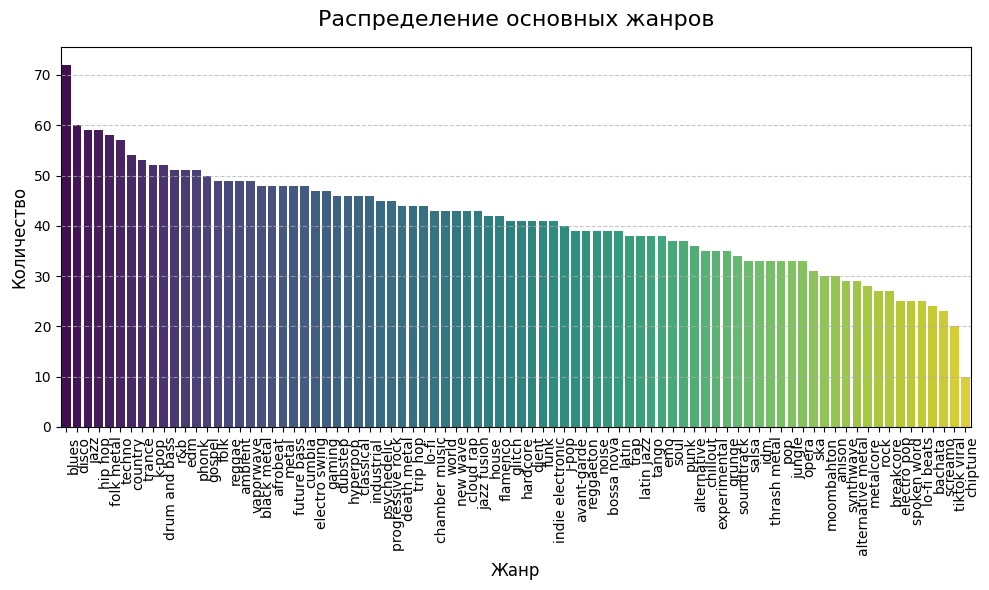

In [37]:
genre_counts = (
    df['main_genre']
    .value_counts()
    .rename_axis('main_genre')
    .reset_index(name='count')
)

plt.figure(figsize=(10, 6))

sns.barplot(
    data=genre_counts,
    x='main_genre',
    y='count',
    hue='main_genre',   # чтобы не было FutureWarning
    palette='viridis',
    dodge=False,        # без «рассеивания» по группам
    legend=False        # отключаем легенду, она здесь избыточна
)

# Оформление
plt.title('Распределение основных жанров', fontsize=16, pad=15)
plt.xlabel('Жанр', fontsize=12)
plt.ylabel('Количество', fontsize=12)
# Поворот подписей и увеличение расстояния между ними
plt.xticks(rotation=90, ha='right', rotation_mode='anchor')

# Увеличиваем отступ снизу, чтобы подписи точно влезли


# Добавляем сетку по Y
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('5.png')
plt.show()

In [ ]:
col = df[df['on_disk'] == 1].groupby('subgenre').count()
col['on_disk']

plt.figure(figsize=(12,6))
col['on_disk'][col['on_disk'] < 7].plot(kind='bar')
plt.xlabel('Subgenre')
plt.ylabel('Количество треков в бд')
plt.title('Subgenre, кол-во которых в датасете меньше 8')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('4.png')
plt.show()

![4](4.png)

In [ ]:
counts_main_genre = df[df['on_disk'] == 1].groupby('main_genre')['main_genre'].count().reset_index(name='count')

plt.figure(figsize=(6, 8))
plt.boxplot(counts_main_genre['count'], vert=True)
plt.ylabel('Number of on‑disk tracks per main_genre')
plt.title('Boxplot by main_genre')
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('3.png')
plt.show()

![3](3.png)

In [ ]:
counts_main_genre = df[df['on_disk']==1].groupby('main_genre')['main_genre'].count().reset_index(name='count')

# Извлекаем саму колонку с числами
counts = counts_main_genre['count']

# Вычисляем квартiles и медиану
Q1 = counts.quantile(0.25)
Q3 = counts.quantile(0.75)
median = counts.median()
IQR = Q3 - Q1

# Границы для определения выбросов (1.5·IQR)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1 = {Q1}")
print(f"Median = {median}")
print(f"Q3 = {Q3}")
print(f"IQR = {IQR}")
print(f"Lower bound = {lower_bound}")
print(f"Upper bound = {upper_bound}")

# Находим жанры‑выбросы
outliers = counts_main_genre[
    (counts_main_genre['count'] < lower_bound) |
    (counts_main_genre['count'] > upper_bound)
]
# 3) Определяем выбросы по правилу 1.5·IQR
Q1 = counts.quantile(0.25)
Q3 = counts.quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
outliers = counts[(counts < lower) | (counts > upper)].index.tolist()

# 4) Готовим explode: «взрываем» кусочки для жанров‑выбросов
explode = [0.1 if genre in outliers else 0.0 for genre in counts.index]

# 5) Строим круговую диаграмму
plt.figure(figsize=(8,8))
plt.pie(
    counts,
    labels=counts.index,
    autopct=lambda pct: f"{pct:.1f}%",
    explode=explode,
    startangle=90,
    pctdistance=0.8
)
plt.title('Распределение main_genre на диске (pie), выделены выбросы')
plt.legend(
    [f"{g} ({counts[g]} треков)" for g in outliers],
    title="Жанры‑выбросы",
    loc="center left",
    bbox_to_anchor=(1,0.5)
)
plt.tight_layout()
plt.savefig('2.png')
plt.show()

![2](2.png)

In [ ]:
import matplotlib.pyplot as plt

# Данные: сколько поджанров имеют k треков на диске
dist = {
    1: 1,
    2: 2,
    3: 2,
    4: 4,
    5: 12,
    6: 16,
    7: 25,
    8: 44,
    9: 84,
    10: 197
}


# Сортируем по ключам (числу треков)
ks = sorted(dist.keys())
vs = [dist[k] for k in ks]
total = sum(vs)
percentages = [(v / total) * 100 for v in vs]

# Строим bar‑chart
plt.figure(figsize=(8,5))
plt.bar(ks, vs)
plt.ylabel('Количество поджанров')
plt.xlabel('Количество треков в поджанре')
plt.title('Баланс датасета по поджанрам')
plt.xticks(ks)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Подписи над барами
for x, y, p in zip(ks, vs, percentages):
    plt.text(x, y + 0.5, f"{y} ({p:.1f}%)", ha='center')

plt.tight_layout()
plt.savefig('1.png')
plt.show()



![1](1.png)